# Evaluation of Perturbations/Randomizations of Data
I conducted experiments in which I perturbed the original data I was using. This notebook computes and plots PR curves from the different perturbations of:
* **the PPI network**. I randomly shuffled 50% or 100% of the edges, preserving the node degree. I also added two random networks, one that preserves the node degree and one that doesn't.
* **the multi-omics features**. I again shuffled 50% or 100% of the node features around. I also added random features (twice to match with the number of perturbations with networks).
* **both of them**. I also created containers where I perturbed both, features and the network.

I expect the performance to drop when the data becomes less informative and more random. At the same time, we know that the study bias of cancer genes is quite high so that I expect much more extreme drops in performance when the node degree is not preserved. The random network with maintained node degree should give us a nice baseline here.

In [12]:
import pandas as pd
import numpy as np
import networkx as nx
import os, sys

from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.ensemble import RandomForestClassifier

sys.path.append(os.path.abspath('../GCN'))
import gcnIO
import postprocessing

sys.path.append(os.path.abspath('../pagerank'))
import pagerank

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Network: 0_networkfeature_perturbation	AUPR: 0.7338158114212125
Network: 0_5_networkfeature_perturbation	AUPR: 0.5755653757097315
Network: 1_networkfeature_perturbation	AUPR: 0.5285238333155734
Network: Random_degreepreserved_networkfeature_perturbation	AUPR: 0.5338563099414455
Network: Random_powerlaw_networkfeature_perturbation	AUPR: 0.7414227929082784


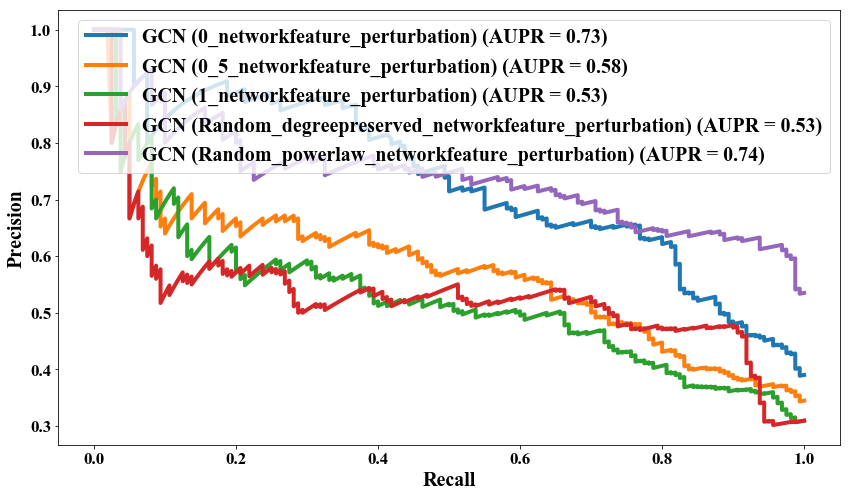

In [18]:
perturbation_folder = '../data/GCN/training/perturbation_netfeat/'

def calculate_metrics(train_dir):
    args, data_file = gcnIO.load_hyper_params(train_dir)
    data = gcnIO.load_hdf_data(data_file)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    predictions = postprocessing.load_predictions(train_dir)
    pred_testset = predictions[predictions.Name.isin(node_names[test_mask, 1])]
    pr, rec, thresholds = precision_recall_curve(y_true=pred_testset.label, probas_pred=pred_testset.Prob_pos)
    aupr = average_precision_score(y_true=pred_testset.label, y_score=pred_testset.Prob_pos)
    return pr, rec, aupr

all_perfs = []
for training in os.listdir(perturbation_folder):
    if not training.startswith('.') and os.path.isdir(os.path.join(perturbation_folder, training)):
        pr, rec, aupr = calculate_metrics(os.path.join(perturbation_folder, training))
        all_perfs.append((pr, rec, aupr, training))
        print ("Network: {}\tAUPR: {}".format(training, aupr))

linewidth = 4
labelfontsize = 20
ticksize = 17

fig = plt.figure(figsize=(14, 8))
for pr, rec, aupr, name in all_perfs:
    plt.plot(rec, pr, lw=linewidth, label='GCN ({0}) (AUPR = {1:.2f})'.format(name, aupr))
plt.legend(fontsize=labelfontsize)
plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.tick_params(axis='both', labelsize=ticksize)

## Random Forest Classifier on perturbed data

Network: 0_networkfeature_perturbation	AUPR: 0.5338839743252222
Network: 0_5_networkfeature_perturbation	AUPR: 0.39189756557999517
Network: 1_networkfeature_perturbation	AUPR: 0.33436365026676773
Network: Random_degreepreserved_networkfeature_perturbation	AUPR: 0.29282690491713587
Network: Random_powerlaw_networkfeature_perturbation	AUPR: 0.3227665388168992


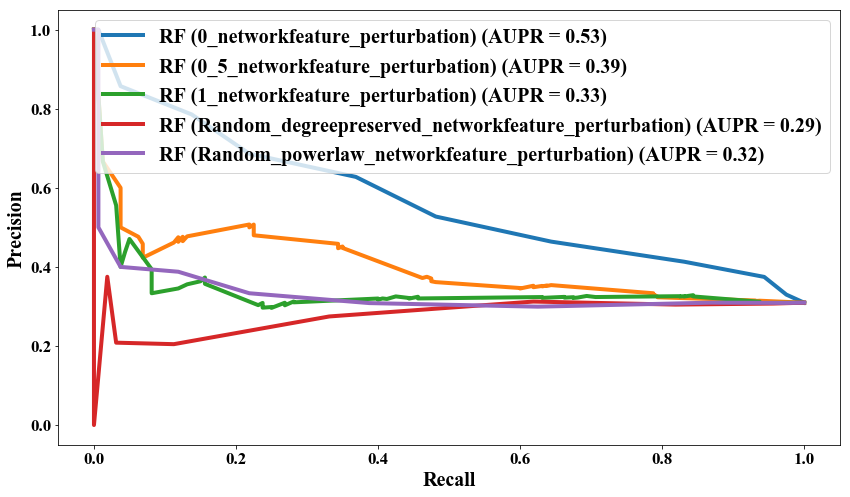

In [19]:
def rf_performance(train_dir):
    args, data_file = gcnIO.load_hyper_params(train_dir)
    data = gcnIO.load_hdf_data(data_file)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    
    # prepare the data for sklearn API
    X_train = features[train_mask.astype(np.bool)]
    y_train_rf = y_train[train_mask.astype(np.bool)]
    X_test = features[test_mask.astype(np.bool)]
    y_test_rf = y_test[test_mask.astype(np.bool)]
    
    # train RF on the data and predict for testset
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train_rf.reshape(-1))
    pred_testset = rf.predict_proba(X_test)

    y_true = y_test[test_mask == 1, 0]
    pr, rec, thresholds = precision_recall_curve(y_true=y_true, probas_pred=pred_testset[:, 1])
    aupr = average_precision_score(y_true=y_true, y_score=pred_testset[:, 1])
    return pr, rec, aupr

all_perfs_rf = []
for training in os.listdir(perturbation_folder):
    if not training.startswith('.') and os.path.isdir(os.path.join(perturbation_folder, training)):
        pr, rec, aupr = rf_performance(os.path.join(perturbation_folder, training))
        all_perfs_rf.append((pr, rec, aupr, training))
        print ("Network: {}\tAUPR: {}".format(training, aupr))
        
linewidth = 4
labelfontsize = 20
ticksize = 17

fig = plt.figure(figsize=(14, 8))
for pr, rec, aupr, name in all_perfs_rf:
    plt.plot(rec, pr, lw=linewidth, label='RF ({0}) (AUPR = {1:.2f})'.format(name, aupr))
plt.legend(fontsize=labelfontsize)
plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.tick_params(axis='both', labelsize=ticksize)

## PageRank algorithm on perturbed data

Maximum Pagerank: Index: 11270	Pagerank: 0.006650312418214648
Minimum Pagerank: Index: 3508	Pagerank: 1.503088157884692e-05
Network: 0_networkfeature_perturbation	AUPR: 0.48916270583136645


/pkg/python-3.6.0-0/lib/python3.6/site-packages/pandas/util/decorators.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return func(*args, **kwargs)


Maximum Pagerank: Index: 11270	Pagerank: 0.006704397004074879
Minimum Pagerank: Index: 3689	Pagerank: 1.5997294007388516e-05
Network: 0_5_networkfeature_perturbation	AUPR: 0.4824634389816065
Maximum Pagerank: Index: 11270	Pagerank: 0.006731988970128728
Minimum Pagerank: Index: 1265	Pagerank: 1.613462097779042e-05
Network: 1_networkfeature_perturbation	AUPR: 0.4822978270821948
Maximum Pagerank: Index: 11270	Pagerank: 0.00592787545205046
Minimum Pagerank: Index: 0	Pagerank: 1.3327307351453697e-05
Network: Random_degreepreserved_networkfeature_perturbation	AUPR: 0.4835512187265336
Maximum Pagerank: Index: 8	Pagerank: 0.0037056732816787806
Minimum Pagerank: Index: 10870	Pagerank: 4.2805805117312576e-05
Network: Random_powerlaw_networkfeature_perturbation	AUPR: 0.3492121137261151


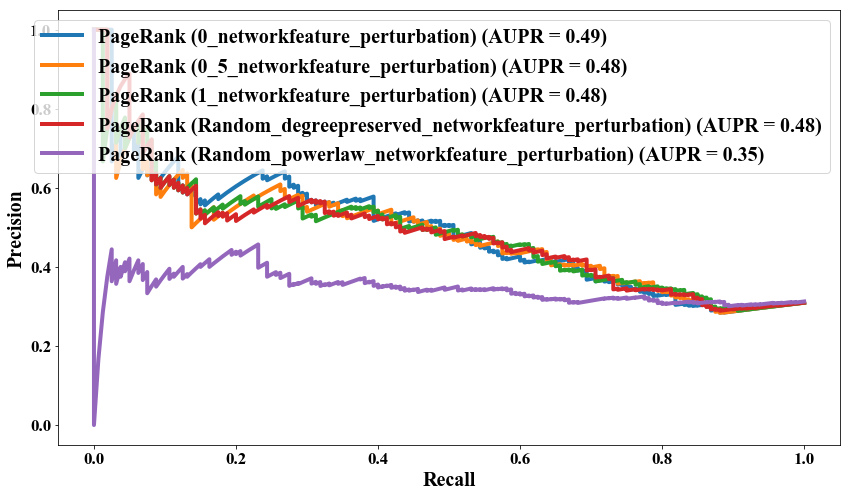

In [20]:
def pagerank_performance(train_dir):
    args, data_file = gcnIO.load_hyper_params(train_dir)
    data = gcnIO.load_hdf_data(data_file)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    y_true = y_test[test_mask == 1, 0]
    
    # run pagerank on the data
    scores, names = pagerank.pagerank(network, node_names)
    pr_df = pd.DataFrame(scores, columns=['Number', 'Score']) # get the results in same order as our data
    names = pd.DataFrame(names, columns=['ID', 'Name'])
    pr_pred_all = pr_df.join(names, on='Number', how='inner')
    pr_pred_all.drop_duplicates(subset='Name', inplace=True)
    node_names_df = pd.DataFrame(node_names, columns=['ID', 'Name']).set_index('ID')
    pr_pred_all = pr_pred_all.set_index('Name').reindex(node_names_df.Name)
    pr_pred_test = pr_pred_all[pr_pred_all.index.isin(node_names[test_mask == 1, 1])]
    pr_pred_test.drop_duplicates(inplace=True)
    
    pr, rec, thresholds = precision_recall_curve(y_true=y_true, probas_pred=pr_pred_test.Score)
    aupr = average_precision_score(y_true=y_true, y_score=pr_pred_test.Score)
    return pr, rec, aupr

all_perfs_pr = []
for training in os.listdir(perturbation_folder):
    if not training.startswith('.') and os.path.isdir(os.path.join(perturbation_folder, training)):
        pr, rec, aupr = pagerank_performance(os.path.join(perturbation_folder, training))
        all_perfs_pr.append((pr, rec, aupr, training))
        print ("Network: {}\tAUPR: {}".format(training, aupr))
        
linewidth = 4
labelfontsize = 20
ticksize = 17

fig = plt.figure(figsize=(14, 8))
for pr, rec, aupr, name in all_perfs_pr:
    plt.plot(rec, pr, lw=linewidth, label='PageRank ({0}) (AUPR = {1:.2f})'.format(name, aupr))
plt.legend(fontsize=labelfontsize)
plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.tick_params(axis='both', labelsize=ticksize)

In [74]:
#test_folder = os.path.join(perturbation_folder, 'Random_powerlaw_networkfeature_perturbation')
test_folder = '/project/gcn/diseasegcn/data/GCN/training/perturbation_network/Random_powerlaw_perturbation/'
args, data_file = gcnIO.load_hyper_params(test_folder)
data = gcnIO.load_hdf_data(data_file)
network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
y_true = y_test[test_mask == 1, 0]
nodes = pd.DataFrame(node_names, columns=['ID', 'Name'])

In [78]:
data = gcnIO.load_hdf_data('../data/netfeat_perturbation/IREF_Random_powerlaw_networkfeature_perturbation.h5')
network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data

In [79]:
y_train.sum(), y_test.sum(), y_val.sum()

(432, 160, 48)

In [47]:
t_train = nodes[y_train]
t_test = nodes[y_test]
t_val = nodes[y_val]
t_val.Name.isin(t_train.Name).sum()

0